<a href="https://colab.research.google.com/github/daniel8691/Image_Rec_Tensorflow/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import json
import zipfile
import os



In [2]:
# used to delete folders with data
# !rm -rf "train"

In [3]:
# !unzip "drive/MyDrive/Dog_breed_project/dog_breed_data/dog-breed-identification.zip" -d "drive/MyDrive/Dog_breed_project/dog_breed_data"

## Problem
Identifying the breed of a dog given an image of a dog

WHen I take a photo of a dog, I want to know what breed of dog it is

## Data
The data was taken from Kaggle's dog breed identification competition: https://www.kaggle.com/c/dog-breed-identification/data

## Evaluation
This will be a file with prediction probabilities for each dog breed of each test image: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features
* dealing with images (unstructured data) so it's best to use deep learning/transfoer learning
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we want to predict them


In [4]:
# import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:"+tf.__version__)
print(f"TFhub version: {hub.__version__}")

# Check for GPU availability
if tf.config.list_physical_devices("GPU"):
  print("Available")
else:
  print("not available")

TF version:2.4.1
TFhub version: 0.11.0
Available


## Get data ready (turn into Tensors)

The data has to be in numerical format for the ML model
Turn the images into numerical values (numerical representations)

Start by assessing the data and checking out the labels


In [5]:
# check out the labels of the data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/labels.csv")

In [6]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,714965afafec13c0fd2f2617dd065aa5,scottish_deerhound
freq,1,126


In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
# check how many images each dog breed has
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

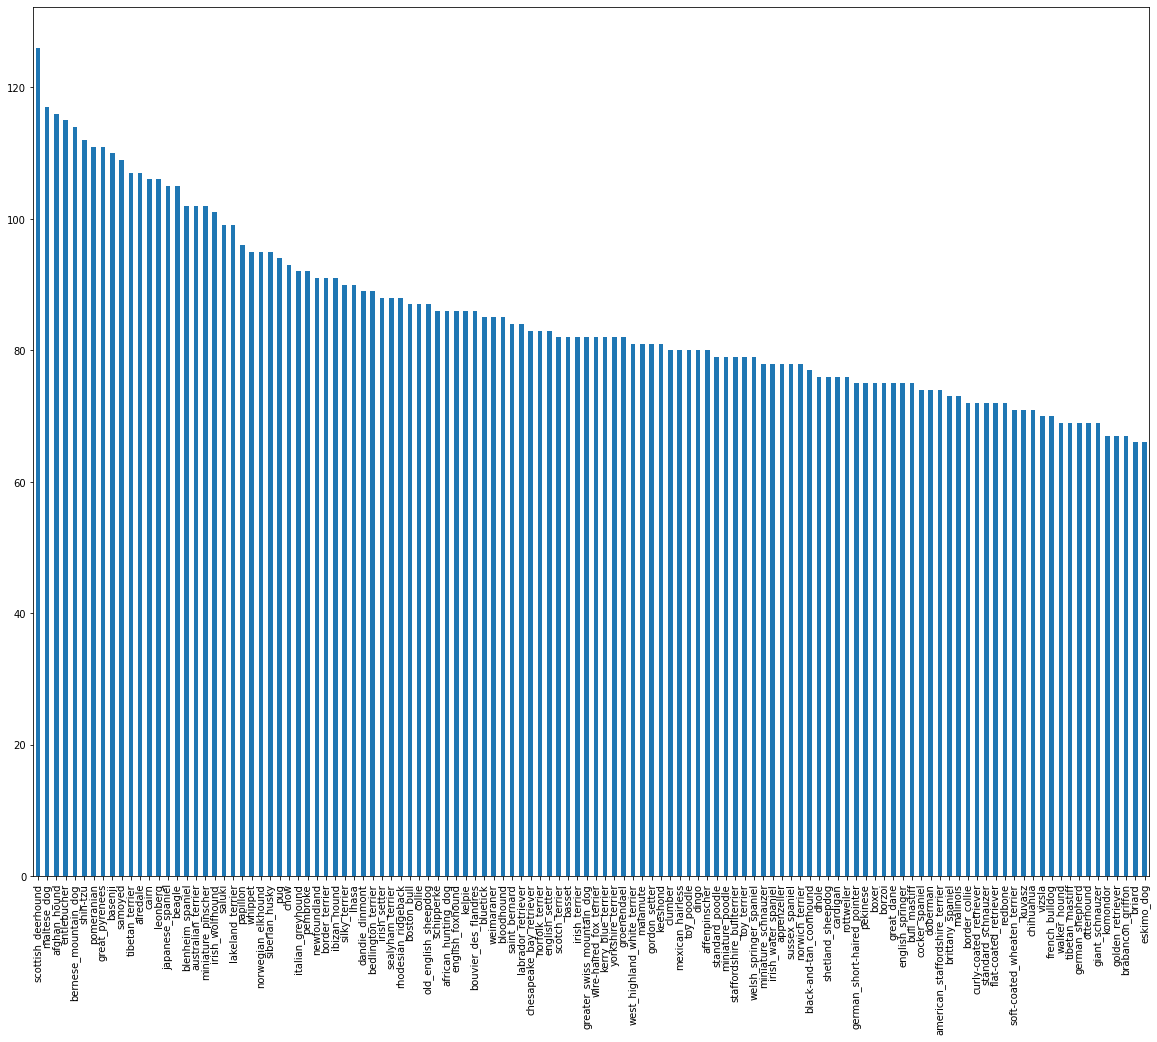

In [9]:
labels_csv['breed'].value_counts().plot(kind='bar', figsize=(20,16))

In [10]:
labels_csv['breed'].value_counts().median()

82.0

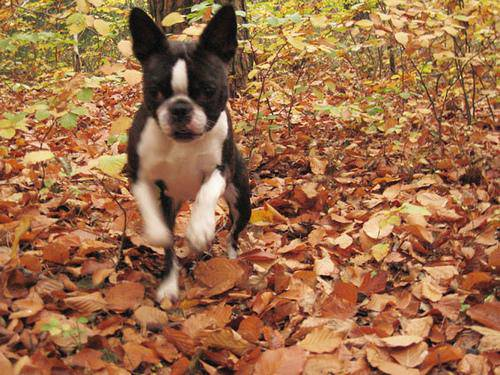

In [11]:
# view an image
from IPython.display  import Image
# pass in file name
Image("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting Images and their labels

get a list of all the image file path names

In [12]:
labels_csv['id'].count()

10222

In [13]:
# Create pathnames from image ID's
fileNames = [fname for fname in labels_csv['id']]

In [14]:
# check the first 10
fileNames[:5]

['000bec180eb18c7604dcecc8fe0dba07',
 '001513dfcb2ffafc82cccf4d8bbaba97',
 '001cdf01b096e06d78e9e5112d419397',
 '00214f311d5d2247d5dfe4fe24b2303d',
 '0021f9ceb3235effd7fcde7f7538ed62']

In [15]:
# get the file names with its file path 
fileNames_path = [f"/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/{fname}.jpg" for fname in labels_csv['id']]

In [16]:
fileNames_path[:5]

['/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [17]:
# check codes
import os
os.listdir("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/")[:10]

['ed650c72271b58dbac0fd5d91ebd206b.jpg',
 'f0efab499435ecd4e634b72f539fde9b.jpg',
 'efd68fb69d154ed0ff2dfea8f782f0d3.jpg',
 'ee92839020f1795e7eab77358e2528f1.jpg',
 'ea77bbe28a68e90a21bbef677493ad65.jpg',
 'f3929a0a7c3fede11ceb5d9e379778db.jpg',
 'f243cb6ec376a19f7de80e9c1a248518.jpg',
 'ecc1a9dcc73f00726ce6a7e79ef10a1c.jpg',
 'f2d5c11258efb9e8de45a81a6982f8f2.jpg',
 'ea9134791fb20bce0b72caabfa0947a6.jpg']

In [18]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/")) == len(fileNames_path):
  print("Filenames match actual number of files")
else:
  print("filenames don't match actual number of files")


Filenames match actual number of files


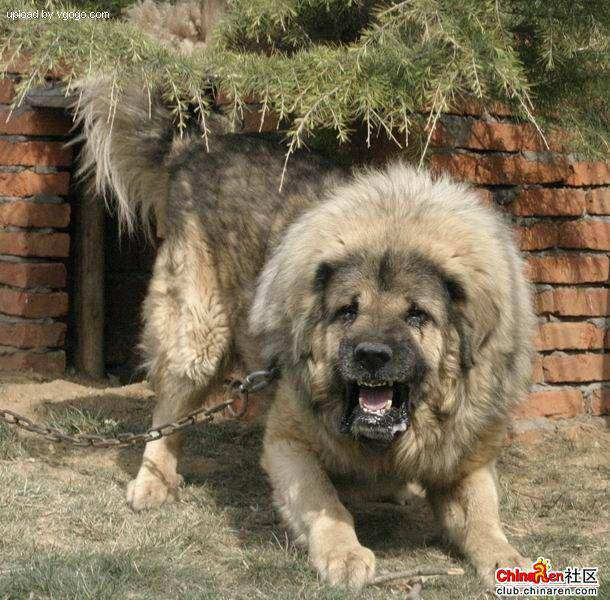

In [19]:
Image(fileNames_path[9000])

In [20]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filpaths in a list, let's prepare the labels

In [21]:
import numpy as np
labels = labels_csv['breed']
labels = np.array(labels)
# labels = label_csv['breed].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [22]:
len(labels)

10222

In [23]:
# check if number of labels matches the number of filenames
if len(labels) == len(fileNames_path):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels doesn't match number of filenames")

Number of labels matches number of filenames


In [24]:
# find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [25]:
# should have 120 unique values (stated in the Kaggle description)
len(unique_breeds)

120

In [26]:
# Turn a single label into an arry of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every single label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

In [31]:
print(len(boolean_labels))

10222


In [32]:
# example: turning boolean array into integers
print(labels[0])
# index where label occurs
print(np.where(unique_breeds == labels[0]))
# indent where label occurs in boolean array
print(boolean_labels[0].argmax()) 
# there should be a 1 where the sample label occurs
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [34]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

since the dataset from kaggle doesn't come with a validaiton set, we have to create our own

Here we'll start off experimenting with ~1000 images and increase as needed (training all the data takes too long)

In [35]:
# set up X & y variables
X = fileNames_path
y = boolean_labels

In [36]:
len(fileNames_path)

10222

In [37]:
len(boolean_labels)

10222

In [38]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [43]:
# split data into train and validation data
from sklearn.model_selection import train_test_split
# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  #reproducible results
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [45]:
# have a look at the training data
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,